#### Importing all the libraries

In [2]:
import matplotlib.pyplot as plt 
import numpy as np 
import os 
import cv2
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.filters import gaussian, sobel, scharr
from skimage.feature import canny
import random
import tensorflow as tf
from tensorflow.keras import utils
import pandas as pd
import seaborn as sns
import pickle


%matplotlib inline

In [47]:
def show_img(num, img_array, title, ncols=1):
    '''this function display images as is - before any pre-processing'''
    ncols= ncols
    nrows= int(num/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize =(ncols*4,nrows*4))
    fig.suptitle(title, size = 20)
    ax = ax.ravel()
    for i in range(num):
        ax[i].imshow(img_array[i][0], cmap='gray')
        #ax[i].imshow(img_array[i][0], cmap='viridis')
        ax[i].set_title(label_map.get(img_array[i][1]), size=16)

In [ ]:
def subplot_images(num, df, img_index, title, ncols=4, target_w=224, target_h=224):
    '''this function shows images from a dataframe with index - together with cropped & resized function'''
    ncols = ncols
    nrows=int(num/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*4),sharex=True, sharey=True)
    fig.suptitle(title, size = 20)
    ax = ax.ravel() 
    for i,img in enumerate(img_index):
        image = df.loc[img,'img_array']
        new_image = crop_and_resize(image, target_w=target_w, target_h=target_h)
        ax[i].imshow(new_image, cmap='gray')
        ax[i].set_title(df.loc[img,'face_shape'], size=16)


In [ ]:
def subplot_img_array(num, img_array, title, ncols=4, target_w=224, target_h=224):
    '''this function shows images from an array dataset - together with cropped & resized function'''
    ncols = ncols
    nrows=int(num/ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*4,nrows*4),sharex=True, sharey=True)
    fig.suptitle(title, size = 20)
    ax = ax.ravel() 
    for i,img in enumerate(img_array):
        image = img_array[i][0]
        new_image = crop_and_resize(image, target_w=target_w, target_h=target_h)
        ax[i].imshow(new_image, cmap='gray')
        ax[i].set_title(label_map.get(img_array[i][1]), size=16)


In [37]:
# print summaries:
def print_summary(train_array, test_array):
    print(f'\nTraining Dataset:\n')
    print(f'Shape: {train_array.shape}')
    print(f'Classes: {np.unique(train_array[:,1])}')
    print(f'No. of Images in each class: {np.bincount(train_array[:,1].astype(int))}')
    print(f'Max Pixels: {np.amax(train_array[0][0][:])}')
    print('\n--------------------------------------\n')
    print(f'\nTesting Dataset:\n')
    print(f'Shape: {test_array.shape}')
    print(f'Classes: {np.unique(test_array[:,1])}')
    print(f'No. of Images in each class: {np.bincount(test_array[:,1].astype(int))}')
    print(f'Max Pixels: {np.amax(test_array[0][0][:])}')
    print('\n--------------------------------------\n')

### Read the whole dataset

In [26]:
train_dir = "FaceShapeDataset/training_set"
test_dir = "FaceShapeDataset/testing_set"
example_dir = "FaceShapeDataset/example_set"
categories = ['Heart','Oblong','Oval','Round','Square']
#categories = ['Oblong','Oval','Round']

#### Map the images to the labels

In [27]:
label_map = {0:'Heart', 1: 'Oblong', 2: 'Oval', 3: 'Round', 4: 'Square'}
#label_map = {0:'Oblong', 1: 'Oval', 2: 'Round'}

In [28]:
def create_data_files(directory, array, resize=None):
    '''this function reads the images from the directory and create training & testing datasets'''
    i=0
    for category in categories:
        path = os.path.join(directory, category)  # path to directory of images
        class_num = categories.index(category)  # assign number to the 5 categories
        img_list = os.listdir(path)
        try:
            for img in img_list:            
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                if resize != None:
                  img_array = cv2.resize(img_array, resize)
                array.append([img_array, class_num])
                i += 1
        except Exception as e:
                print(f'Error: \n category: {category}\n image: {img}')
    
        # Print progress every 400 images
        if i % 200 == 0:
            print(f"Images processed: {i} of {len(img_list*len(categories))}")

In [29]:
# create training & testing data into a list

training_data = []
testing_data = []

create_data_files(train_dir, training_data)
create_data_files(test_dir, testing_data)

Premature end of JPEG file


Images processed: 800 of 4000
Images processed: 1600 of 4000
Images processed: 2400 of 4000
Images processed: 3200 of 4000


Premature end of JPEG file


Images processed: 4000 of 4000
Images processed: 200 of 1000
Images processed: 400 of 1000
Images processed: 600 of 1000
Images processed: 800 of 1000
Images processed: 1000 of 1000


In [25]:
print(len(training_data))

2400


In [34]:
# # Set the directory path where the images are located
# nilay = "FaceShapeDataset/training_set/Heart"

# # Loop through all the files in the directory
# for filename in os.listdir(nilay):
#     if filename.endswith(".jpg") or filename.endswith(".jpeg"):
#         # If the file is a JPEG image, print its name
#         a = 1
#         #print(os.path.join(nilay, filename))
#     else:
#         print('fault')
#         print(os.path.join(nilay, filename))


In [35]:
# convert them to numpy arrays

training_data = np.asarray(training_data,dtype='object')
testing_data = np.asarray(testing_data,dtype='object')

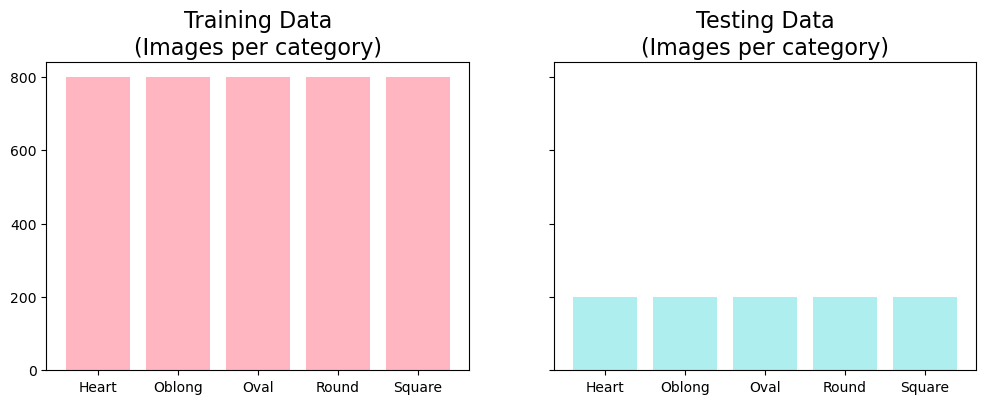

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4),sharex=True, sharey=True)
ax[0].bar(x=categories, height = np.bincount(training_data[:,1].astype(int)),color='lightpink')
ax[0].set_title('Training Data\n(Images per category)', size=16)
ax[1].bar(x=categories, height = np.bincount(testing_data[:,1].astype(int)),color='paleturquoise')
ax[1].set_title('Testing Data\n(Images per category)', size=16)
ax[1].set_yticks(range(0,801,200));

In [38]:
print_summary(training_data, testing_data)


Training Dataset:

Shape: (4000, 2)
Classes: [0 1 2 3 4]
No. of Images in each class: [800 800 800 800 800]
Max Pixels: 255

--------------------------------------


Testing Dataset:

Shape: (1000, 2)
Classes: [0 1 2 3 4]
No. of Images in each class: [200 200 200 200 200]
Max Pixels: 252

--------------------------------------



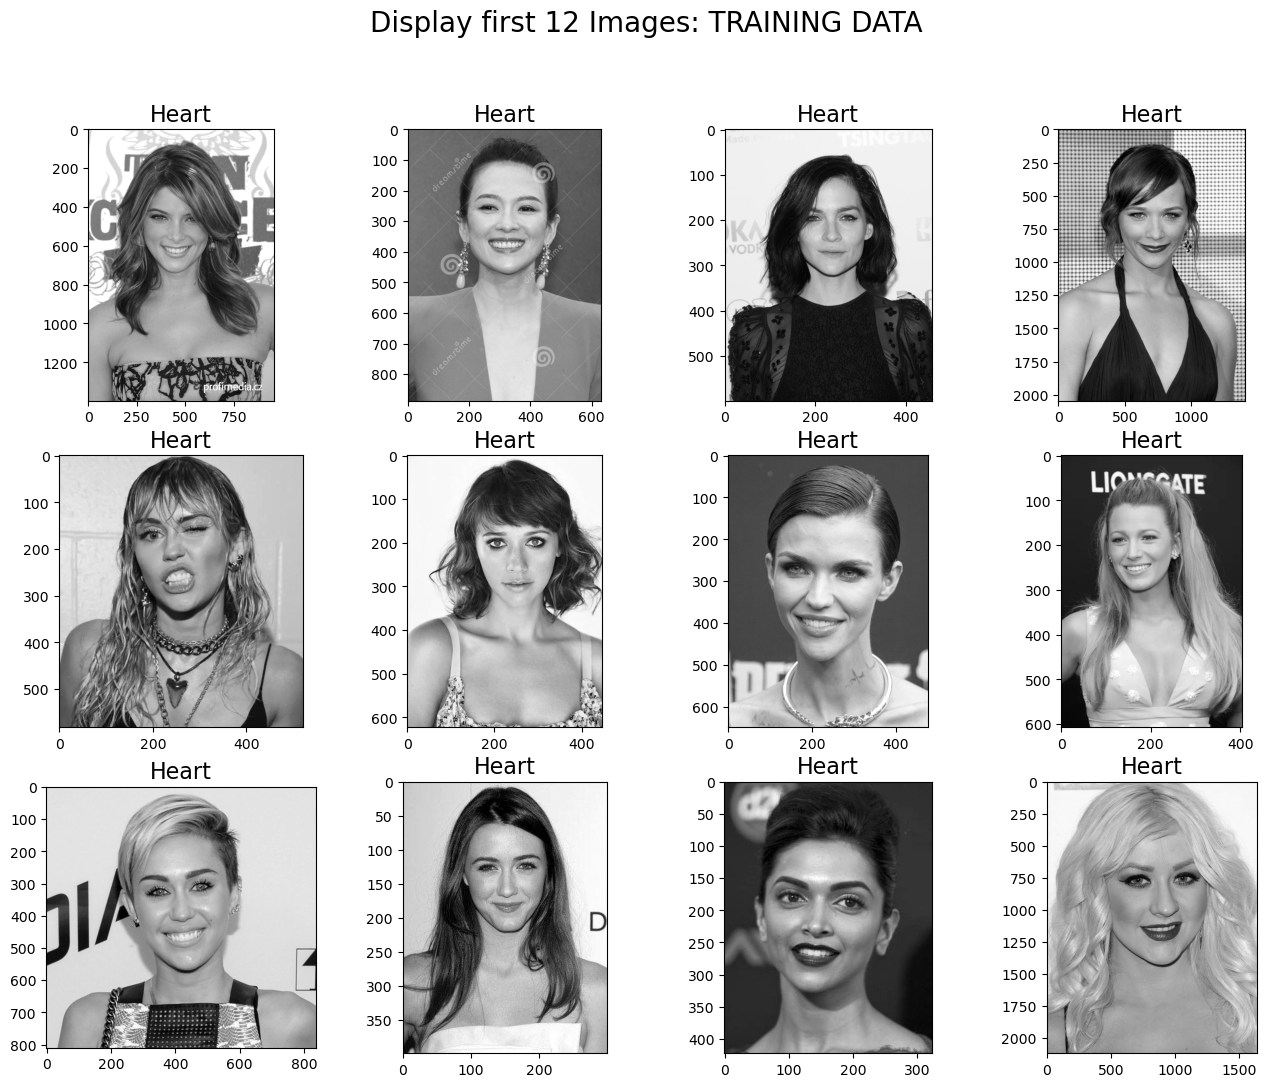

In [48]:
show_img(12, training_data[:12], 'Display first 12 Images: TRAINING DATA', ncols=4)

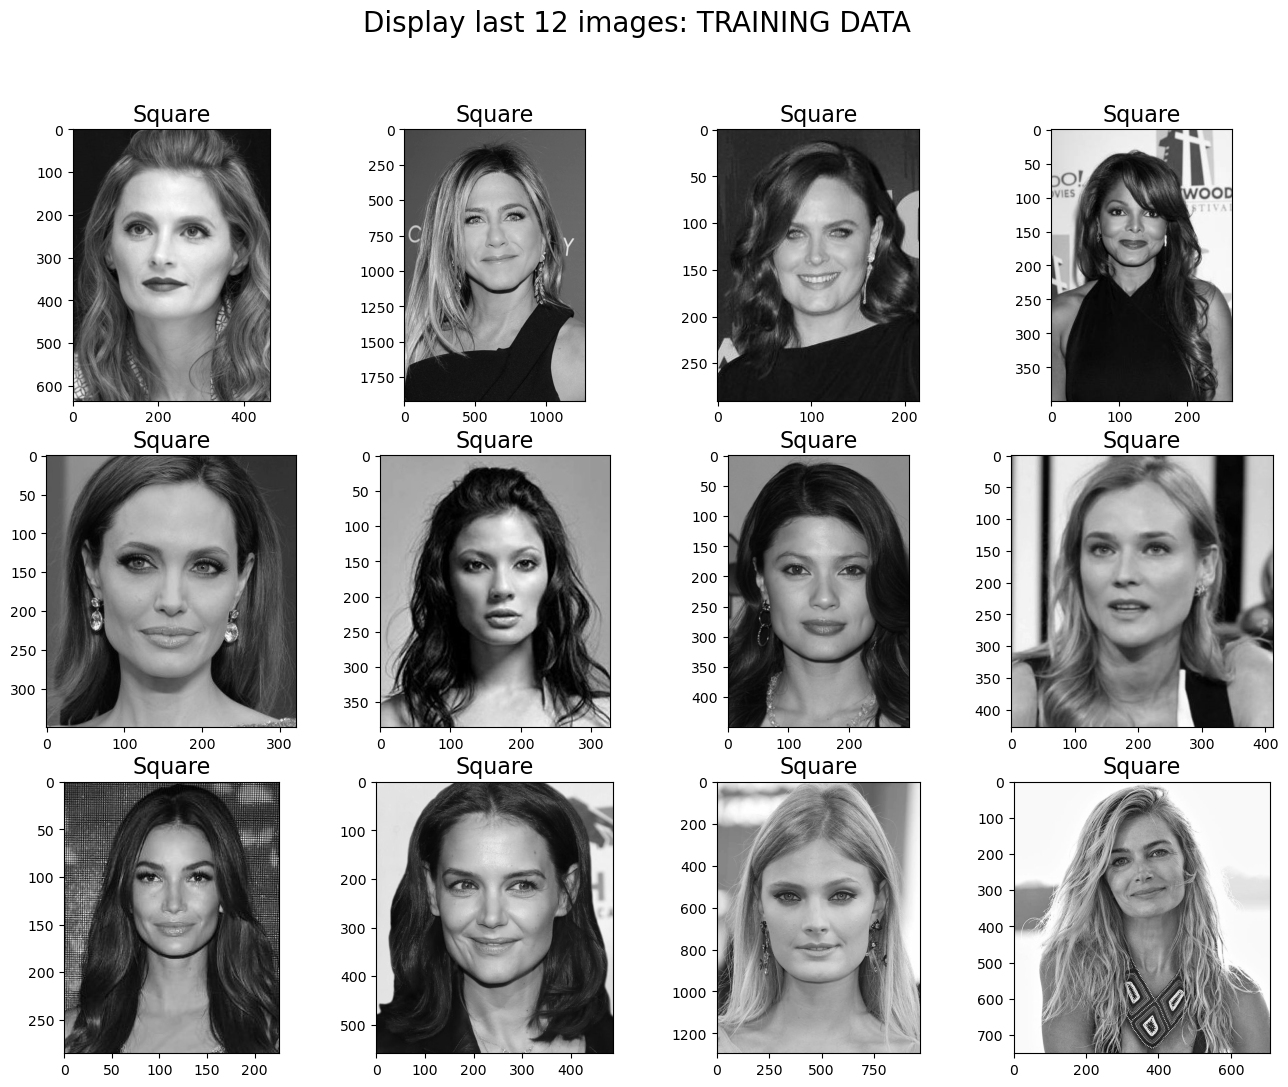

In [49]:
show_img(12, training_data[len(training_data)-12:], 'Display last 12 images: TRAINING DATA', ncols=4)

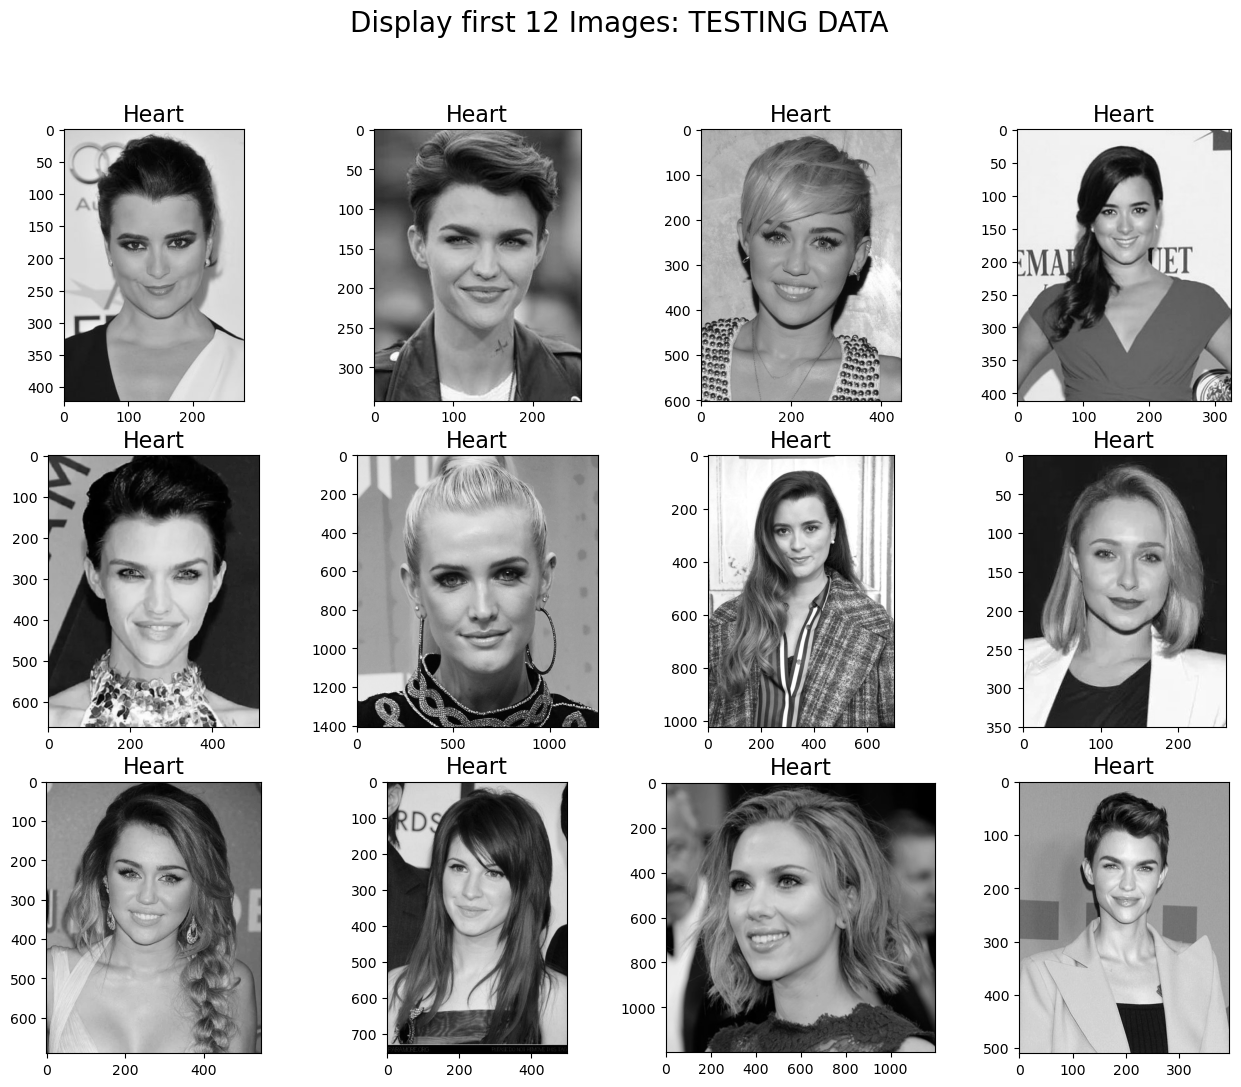

In [50]:
show_img(12, testing_data[:12], 'Display first 12 Images: TESTING DATA', ncols=4)

In [55]:
# Add all the image shapes into an array

shape = []

for image, label in training_data:
    try:
        img_shape = image.shape
        shape.append(img_shape)
    except AttributeError:
        print("shape not found")

shape[:5]

[(1400, 958), (888, 633), (600, 457), (2048, 1404), (582, 522)]

In [59]:
# Create a data frame with the images and their shapes

train = pd.DataFrame(training_data, columns=['img_array','class'])
train['img_shape'] = pd.Series(shape)
train['face_shape'] = train['class'].map(label_map) 
train.head(2)

img_array class    img_shape  \
0  [[208, 208, 208, 208, 208, 208, 208, 208, 208,...     0  (1400, 958)   
1  [[117, 116, 115, 113, 113, 113, 114, 115, 114,...     0   (888, 633)   

  face_shape  
0      Heart  
1      Heart

In [60]:
train.sort_values(by='img_shape', ascending=False)

img_array class     img_shape  \
2479  [[180, 185, 191, 197, 201, 204, 208, 211, 213,...     3  (9999, 6659)   
733   [[160, 162, 161, 159, 159, 161, 162, 160, 164,...     0  (5000, 3333)   
1341  [[179, 179, 179, 178, 178, 177, 177, 177, 179,...     1  (4752, 3168)   
1114  [[184, 184, 184, 184, 184, 184, 184, 184, 181,...     1  (4752, 3168)   
2567  [[239, 239, 238, 238, 238, 238, 239, 239, 236,...     3  (4493, 3267)   
...                                                 ...   ...           ...   
3131  [[239, 239, 239, 239, 239, 239, 239, 239, 239,...     3    (175, 146)   
3116  [[179, 177, 178, 180, 181, 179, 179, 180, 180,...     3    (174, 130)   
1155  [[239, 239, 238, 238, 238, 238, 237, 237, 236,...     1    (174, 127)   
2741  [[138, 139, 140, 140, 140, 140, 140, 140, 141,...     3    (168, 113)   
1390  [[11, 5, 26, 26, 160, 225, 215, 220, 209, 224,...     1    (159, 112)   

     face_shape  
2479      Round  
733       Heart  
1341     Oblong  
1114     Oblong  
2567      Round  
...         ...  
3131      Round  
3116      Round  
1155     Oblong  
2741      Round  
1390     Oblong  

[4000 rows x 4 columns]

In [61]:
# Check the info, make sure there are no null values

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   img_array   4000 non-null   object
 1   class       4000 non-null   object
 2   img_shape   4000 non-null   object
 3   face_shape  4000 non-null   object
dtypes: object(4)
memory usage: 125.1+ KB


In [62]:
# Create Height, Width, and Aspect Ratio for further analysis

train['height'] = train['img_shape'].map(lambda x : x[0], na_action='ignore')
train['width'] = train['img_shape'].map(lambda x : x[1], na_action='ignore')
train['aspect_ratio'] = train['width'] / train['height']
train

img_array class     img_shape  \
0     [[208, 208, 208, 208, 208, 208, 208, 208, 208,...     0   (1400, 958)   
1     [[117, 116, 115, 113, 113, 113, 114, 115, 114,...     0    (888, 633)   
2     [[214, 225, 235, 239, 240, 240, 238, 234, 225,...     0    (600, 457)   
3     [[166, 163, 155, 147, 144, 143, 139, 133, 124,...     0  (2048, 1404)   
4     [[214, 214, 215, 216, 216, 216, 215, 214, 215,...     0    (582, 522)   
...                                                 ...   ...           ...   
3995  [[83, 109, 123, 141, 163, 171, 181, 192, 203, ...     4    (428, 412)   
3996  [[36, 40, 48, 32, 53, 19, 52, 37, 44, 39, 38, ...     4    (286, 226)   
3997  [[233, 233, 233, 233, 232, 231, 230, 230, 230,...     4    (559, 488)   
3998  [[250, 250, 250, 250, 250, 249, 249, 248, 248,...     4   (1295, 970)   
3999  [[253, 252, 251, 250, 249, 249, 249, 249, 249,...     4    (751, 709)   

     face_shape  height  width  aspect_ratio  
0         Heart    1400    958      0.684286  
1         Heart     888    633      0.712838  
2         Heart     600    457      0.761667  
3         Heart    2048   1404      0.685547  
4         Heart     582    522      0.896907  
...         ...     ...    ...           ...  
3995     Square     428    412      0.962617  
3996     Square     286    226      0.790210  
3997     Square     559    488      0.872987  
3998     Square    1295    970      0.749035  
3999     Square     751    709      0.944075  

[4000 rows x 7 columns]

In [63]:
train.describe()

height        width  aspect_ratio
count  4000.000000  4000.000000   4000.000000
mean    728.793750   566.076250      0.791985
std     557.343564   415.075174      0.131070
min     159.000000   112.000000      0.504630
25%     400.000000   305.000000      0.718403
50%     566.500000   447.000000      0.765208
75%     852.250000   680.000000      0.822629
max    9999.000000  6659.000000      1.818182

In [64]:
# Defines a function to plot histograms showing comparative distributions of variables in a dataframe

def subplot_histograms(dataframe, list_of_columns, list_of_titles, list_of_xlabels, list_of_ylabels, 
                       figsize=(10,8), bins = 15,ncols=2,nrows=0, sharex=True, sharey=True, figtitle=None):
    """plot histograms with subplots in matplotlib"""
    if nrows == 0:
        nrows = int(np.ceil(len(list_of_columns)/2)) # Makes sure you have enough rows
    fig, ax = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                           sharex=sharex, sharey=sharey) # You'll want to specify your figsize
    fig.suptitle(figtitle, fontsize=16)
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        ax[i].hist(dataframe[column],bins=bins, color='mediumaquamarine') # feel free to add more settings
        ax[i].set_title(list_of_titles[i])# Set titles, labels, etc here for each subplot
        if (i >= (ncols*nrows)/2):
            ax[i].set_xlabel(list_of_xlabels[i])  # only show x labels on bottom ax plots
        if (sharey==True) and (i % ncols == 0):
            ax[i].set_ylabel(list_of_ylabels[i])  # only show y labels on left ax plots
    plt.tight_layout()
    # plt.savefig(f'../plots/{figtitle}.png');

In [69]:
# plt.style.use('seaborn')
# subplot_histograms(train, ['height', 'width'], 
#                    ['Image Height', 'Image Width'], 
#                    ['pixels','pixels'], 
#                    ['no.of images','no.of images'], 
#                    figsize=(10,8), bins = 40,ncols=1,nrows=2, 
#                    sharex=True, sharey=True, figtitle=None)

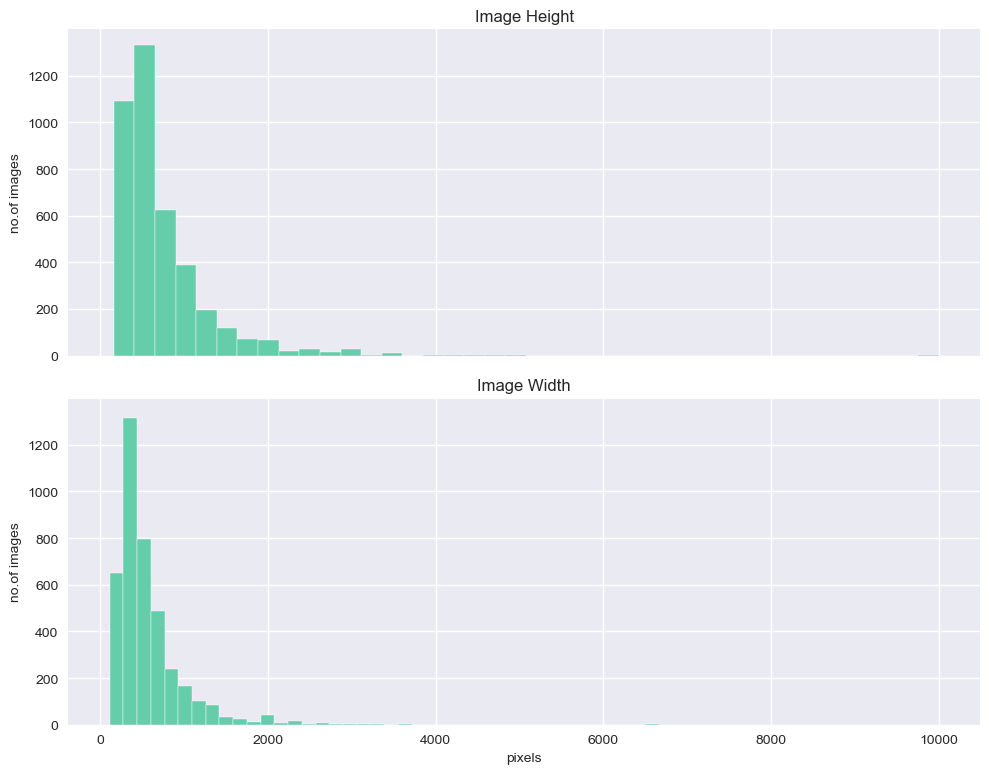

In [70]:
import seaborn as sns

sns.set_style('darkgrid')

subplot_histograms(train, ['height', 'width'], 
                   ['Image Height', 'Image Width'], 
                   ['pixels','pixels'], 
                   ['no.of images','no.of images'], 
                   figsize=(10,8), bins = 40,ncols=1,nrows=2, 
                   sharex=True, sharey=True, figtitle=None)


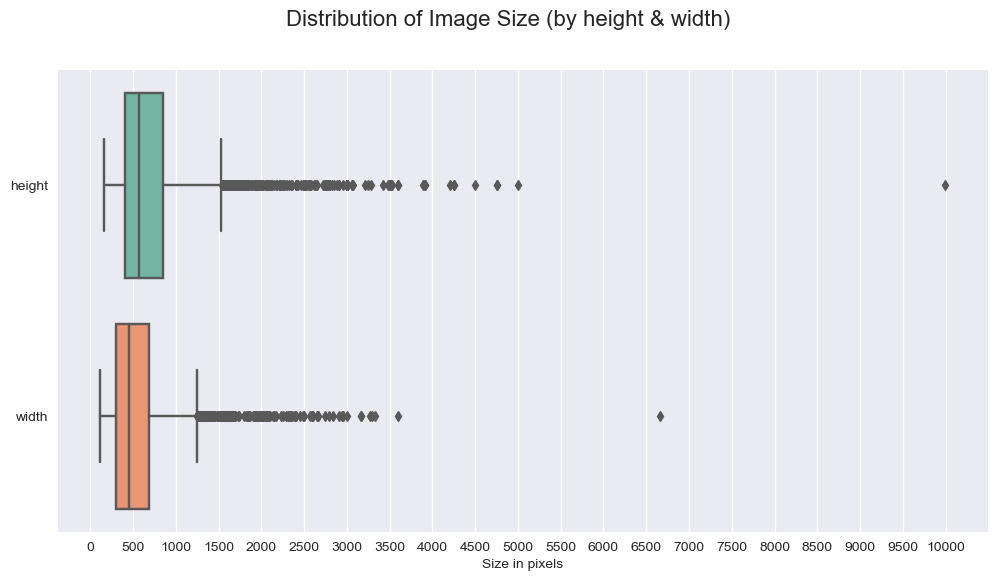

In [74]:
fig,ax = plt.subplots(figsize=(12,6))
fig.suptitle('Distribution of Image Size (by height & width)', fontsize=16)
sns.boxplot(data=train[['height', 'width']],orient='h', palette='Set2')
ax.set_xlabel('Size in pixels')
ax.set_xticks(range(0,10001, 500));
#sns.stripplot(data=train[['height', 'width']],orient='h', alpha=0.05);



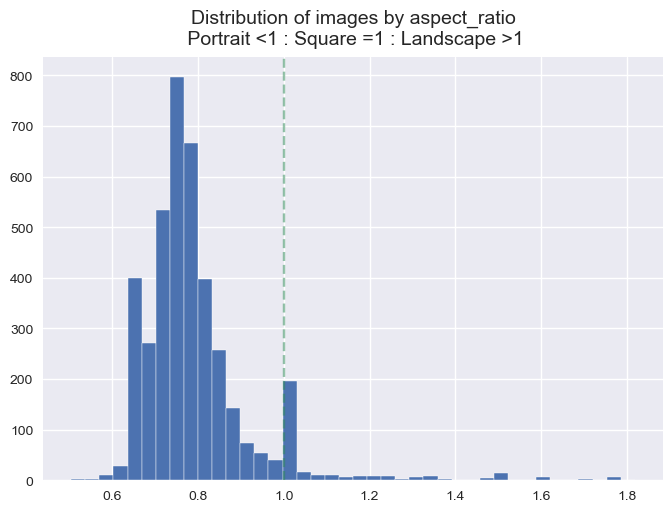

In [75]:
plt.hist(train['aspect_ratio'],bins=40)
plt.title('Distribution of images by aspect_ratio\n Portrait <1 : Square =1 : Landscape >1', fontsize = 14, y=1.01);
plt.axvline(x=1, alpha=0.5, linestyle='--', color='seagreen');

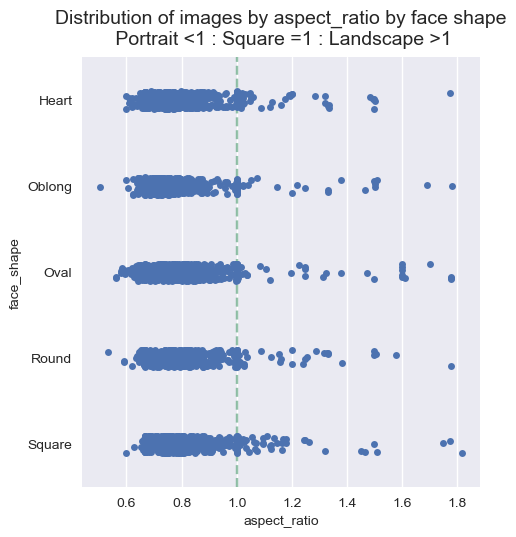

In [76]:
fig.suptitle('Image by Aspect Ratio (square=1)')
sns.catplot(data=train, x='aspect_ratio',y='face_shape')
plt.title('Distribution of images by aspect_ratio by face shape\n Portrait <1 : Square =1 : Landscape >1', fontsize = 14, y=1.01);
plt.axvline(x=1, alpha=0.5, linestyle='--', color='seagreen');

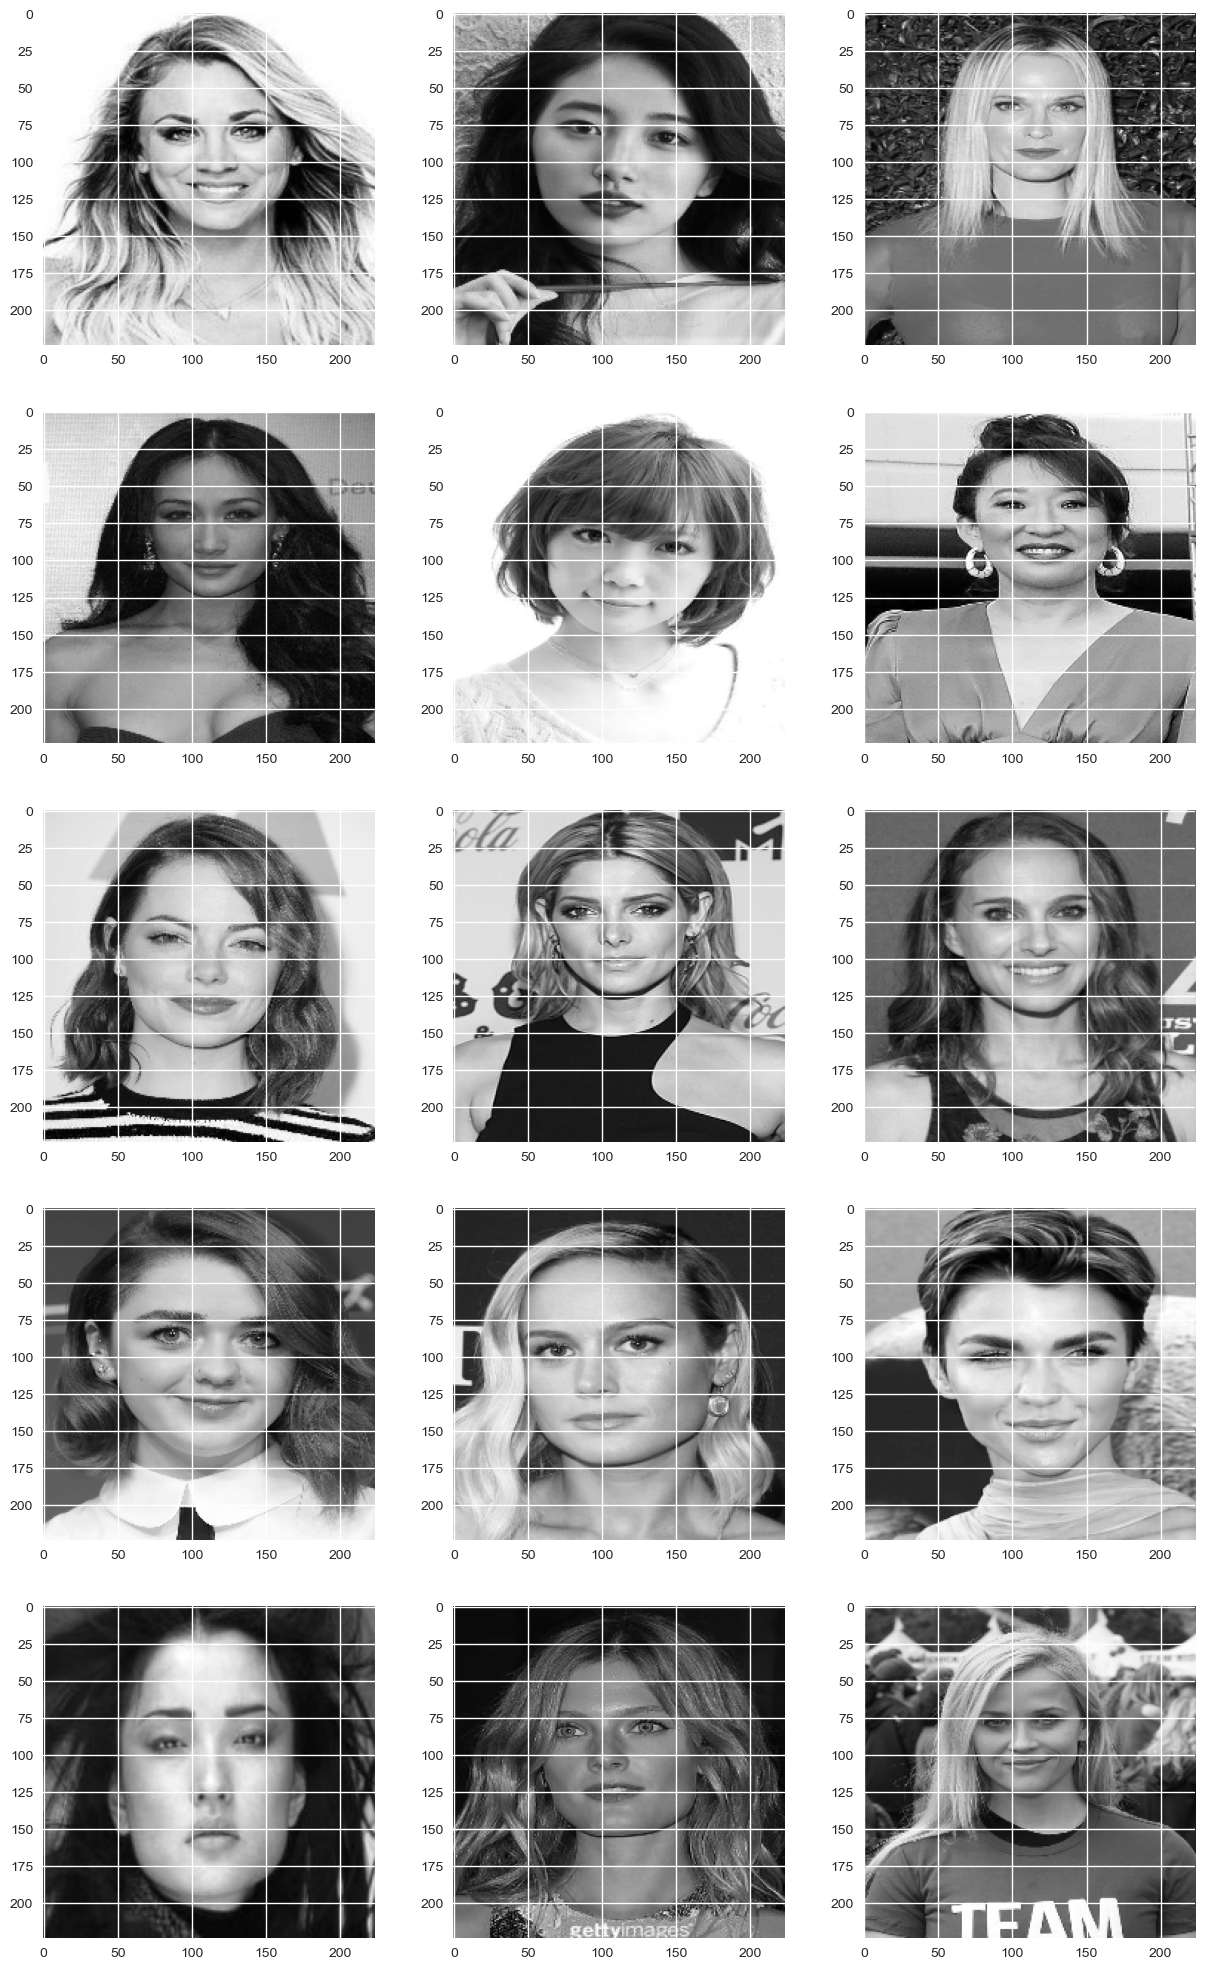

In [77]:
# let's randomly resize 10 images and see what they look like

randomlist = random.sample(range(0, 3998), 15)
img_size = 224
fig, ax = plt.subplots(nrows = 5, ncols=3, figsize = (15,25))
ax = ax.ravel()
for i,img in enumerate(randomlist):
    image = train.loc[img,'img_array']
    new_image = cv2.resize(image, (img_size, img_size))
    ax[i].imshow(new_image, cmap='gray')

In [78]:
def train_test_prep(training_data_array, testing_data_array):
    
    # shuffle the images to mix all the 5 classes randomly
    random.shuffle(training_data_array)
    random.shuffle(testing_data_array)
    
    # read and split X_train, X_test, y_train, y_test into an array
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    for features, label in training_data_array:
        X_train.append(features)
        y_train.append(label)

    for features, label in testing_data_array:
        X_test.append(features)
        y_test.append(label)

    # change data types/format for X
    X_train = np.array(X_train, dtype=float)
    X_test = np.array(X_test, dtype=float)

    X_train = X_train/255
    X_test = X_test/255

    # change values of y to categorical
    y_train = utils.to_categorical(y_train, 5)  
    y_test = utils.to_categorical(y_test, 5)

    return(X_train, X_test, y_train, y_test)

In [79]:
def pickle_out(X_train, X_test, y_train, y_test, version):
    '''to save the data out for modelling'''
    data_path = 'data/'
    name_xtn = data_path + 'X_train_' + version +'.pickle'
    pickle_out = open(name_xtn,"wb")
    pickle.dump(X_train, pickle_out)
    pickle_out.close()

    name_ytn = data_path + 'y_train_' + version +'.pickle'
    pickle_out = open(name_ytn,"wb")
    pickle.dump(y_train, pickle_out)
    pickle_out.close()

    name_xts = data_path + 'X_test_' + version +'.pickle'
    pickle_out = open(name_xts,"wb")
    pickle.dump(X_test, pickle_out)
    pickle_out.close()

    name_yts = data_path + 'y_test_' + version +'.pickle'    
    pickle_out = open(name_yts,"wb")
    pickle.dump(y_test, pickle_out)
    pickle_out.close()

In [80]:
# create new training & testing data with resizing

training_data = []
testing_data = []

create_data_files(train_dir, training_data, (224,224))
create_data_files(test_dir, testing_data, (224,224))

Premature end of JPEG file


Images processed: 800 of 4000
Images processed: 1600 of 4000
Images processed: 2400 of 4000
Images processed: 3200 of 4000


Premature end of JPEG file


Images processed: 4000 of 4000
Images processed: 200 of 1000
Images processed: 400 of 1000
Images processed: 600 of 1000
Images processed: 800 of 1000
Images processed: 1000 of 1000


In [83]:
X_train, X_test, y_train, y_test = train_test_prep(training_data, testing_data)

print(f'X_train.shape {X_train.shape}')
print(f'X_test.shape {X_test.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'y_test.shape {y_test.shape}')

X_train.shape (4000, 224, 224)
X_test.shape (1000, 224, 224)
y_train.shape (4000, 5)
y_test.shape (1000, 5)


In [84]:
X_train = np.array(X_train).reshape(-1, 224, 224, 1)
X_test = np.array(X_test).reshape(-1, 224, 224, 1)

print(f'X_train.shape {X_train.shape}')
print(f'X_test.shape {X_test.shape}')
print(f'y_train.shape {y_train.shape}')
print(f'y_test.shape {y_test.shape}')

X_train.shape (4000, 224, 224, 1)
X_test.shape (1000, 224, 224, 1)
y_train.shape (4000, 5)
y_test.shape (1000, 5)


In [85]:
# need to comment out this part after running this code & generating pickle files
# otherwise it will append to existing file everytime we run it

#pickle_out(X_train, X_test, y_train, y_test, 'r224')

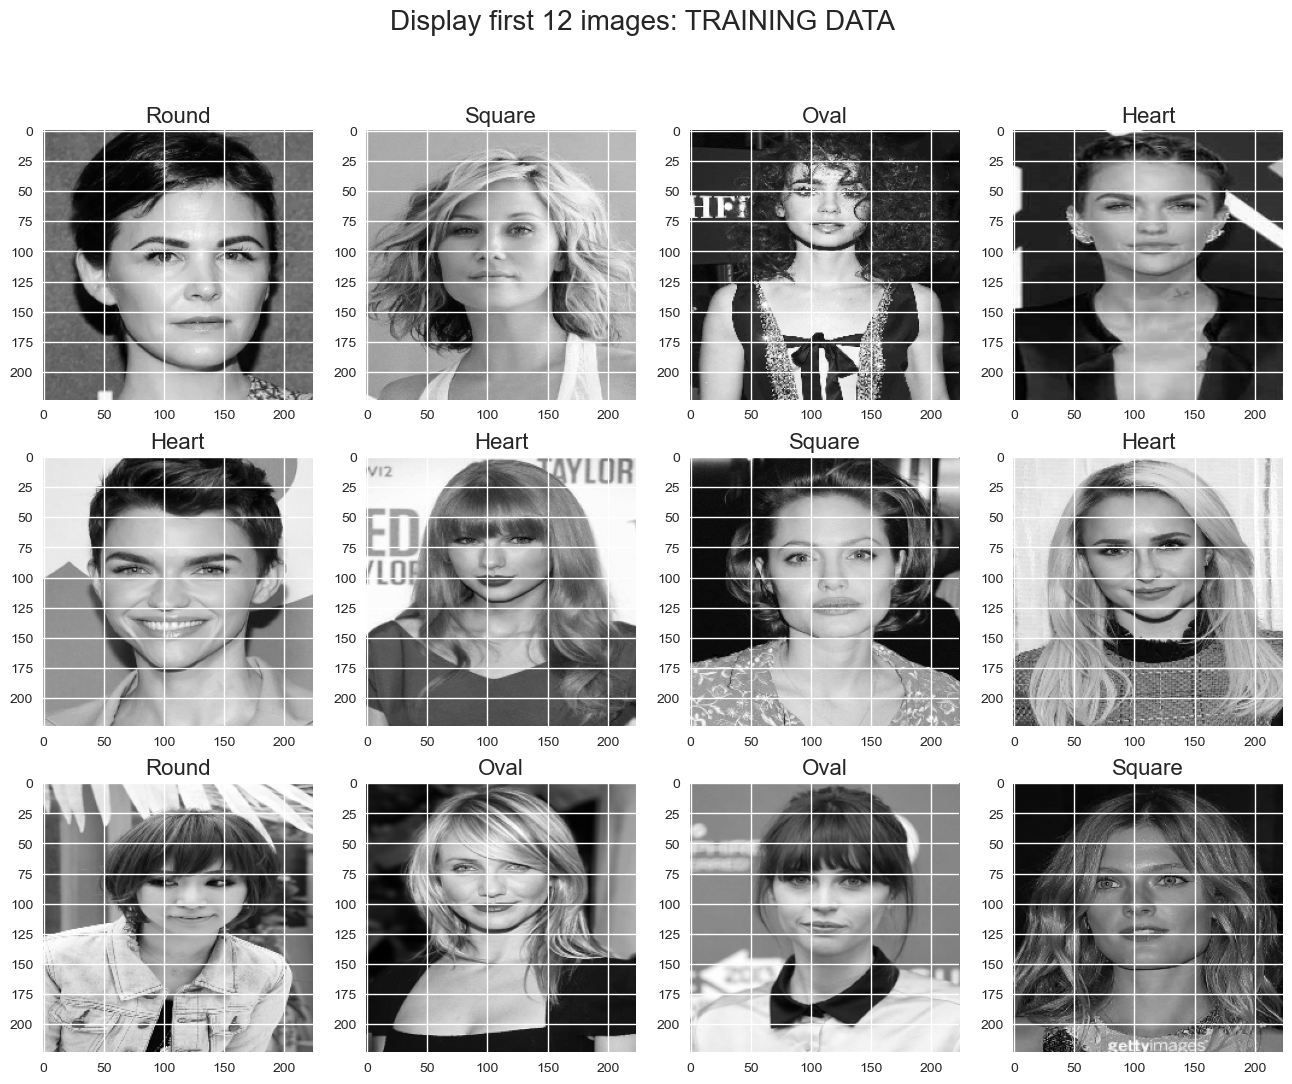

In [86]:
show_img(12, training_data[:12], 'Display first 12 images: TRAINING DATA', ncols=4)

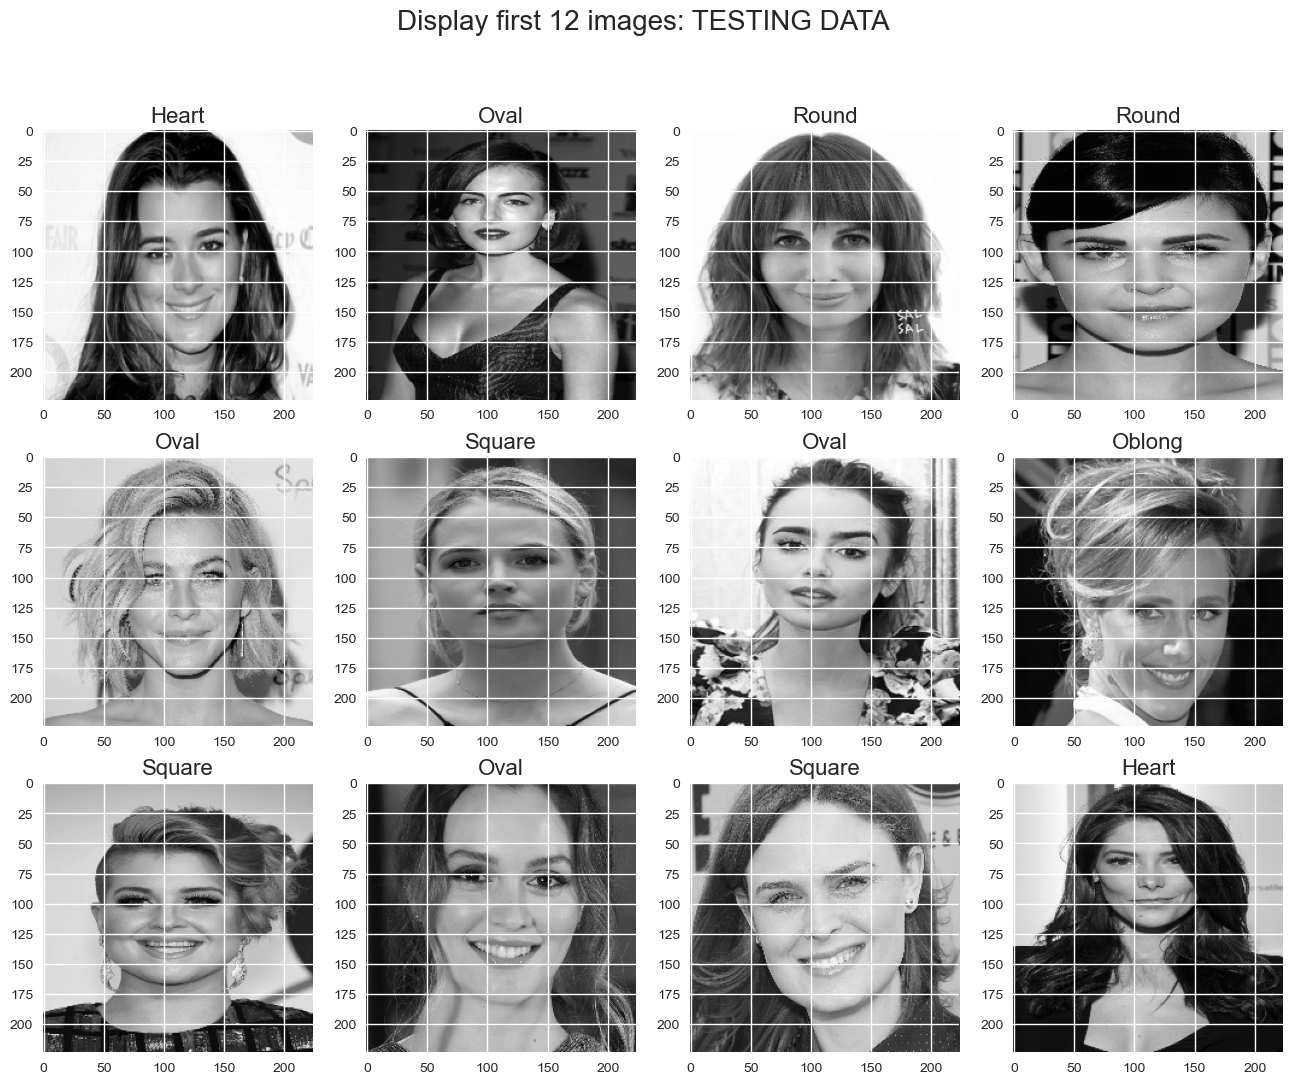

In [87]:
show_img(12, testing_data[:12], 'Display first 12 images: TESTING DATA', ncols=4)